Preprocessing Data is an important part, in making any ML model. Hence, we will learn how to do preprocessing of Image data.

In [0]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

#Interactive plots
plt.ion()

### What is __future__ in python and how it is used?
[link to the docs](https://docs.python.org/3/library/__future__.html)

[link to stack_overflow answer](https://stackoverflow.com/questions/7075082/what-is-future-in-python-used-for-and-how-when-to-use-it-and-how-it-works)

### Get the Dataset

In [3]:
!wget https://download.pytorch.org/tutorial/faces.zip

--2019-08-09 15:50:48--  https://download.pytorch.org/tutorial/faces.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.2.116, 13.224.2.121, 13.224.2.111, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.2.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5780252 (5.5M) [application/zip]
Saving to: ‘faces.zip’

faces.zip           100%[===================>]   5.51M  26.9MB/s    in 0.2s    

2019-08-09 15:50:48 (26.9 MB/s) - ‘faces.zip’ saved [5780252/5780252]



In [0]:
os.makedirs("./data/")
!unzip /content/faces.zip -d /content/data/

In [13]:
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')
print(f'Total number of images : {landmarks_frame.shape}')
landmarks_frame.head(3)

Total number of images : (69, 137)


,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,part_4_y,part_5_x,part_5_y,part_6_x,part_6_y,part_7_x,part_7_y,part_8_x,part_8_y,part_9_x,part_9_y,part_10_x,part_10_y,part_11_x,part_11_y,part_12_x,part_12_y,part_13_x,part_13_y,part_14_x,part_14_y,part_15_x,part_15_y,part_16_x,part_16_y,part_17_x,part_17_y,part_18_x,part_18_y,part_19_x,...,part_48_x,part_48_y,part_49_x,part_49_y,part_50_x,part_50_y,part_51_x,part_51_y,part_52_x,part_52_y,part_53_x,part_53_y,part_54_x,part_54_y,part_55_x,part_55_y,part_56_x,part_56_y,part_57_x,part_57_y,part_58_x,part_58_y,part_59_x,part_59_y,part_60_x,part_60_y,part_61_x,part_61_y,part_62_x,part_62_y,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,139,49,150,60,159,73,166,87,168,100,166,111,160,120,151,128,141,133,128,137,116,138,102,138,89,44,70,53,66,63,...,71,137,78,131,85,127,90,129,94,129,99,134,103,142,97,144,92,145,88,145,83,144,77,141,75,137,85,134,89,135,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,320,100,340,111,359,126,375,149,379,175,376,197,364,218,346,236,322,249,296,254,266,256,237,256,207,65,210,69,197,80,...,110,314,117,310,126,308,135,309,147,307,164,306,184,307,167,317,152,321,139,323,130,322,120,318,114,313,127,312,136,313,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,169,80,180,91,189,103,195,115,197,128,197,139,192,148,184,154,173,160,162,164,150,169,138,171,126,80,101,87,95,98,...,101,163,109,157,117,155,123,157,129,156,134,160,139,168,133,171,126,172,120,172,114,171,107,168,104,162,116,161,122,162,128,162,136,167,127,166,121,165,116,164


In [14]:
n = 65   #index of image
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


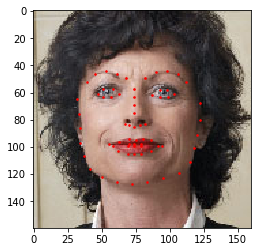

In [6]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.imshow(image)
    
show_landmarks(io.imread(os.path.join('data/faces/', img_name)),
               landmarks)

In [0]:
# Dataset class
'''
    Our dataset should inherit torch.utils.data.Dataset and override 
    __len__  --> returns size of the dataset
    __getitem__  --> get the ith image
'''

class FaceLandmarksDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir           #directory with all the images
        self.transform = transform         #optional transform to be applied on a sample

    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array(landmarks)
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image':image, 'landmarks':landmarks}

        if self.transform:
            sample = self.transform(sample)
        return sample

In [0]:
csv_file='data/faces/face_landmarks.csv'
root_dir = '/content/data/faces'
face_dataset = FaceLandmarksDataset(csv_file, root_dir)

0 (324, 215, 3) (68, 2)
1 (500, 333, 3) (68, 2)
2 (250, 258, 3) (68, 2)
3 (434, 290, 3) (68, 2)


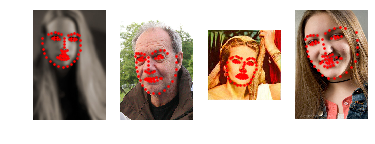

In [15]:
fig = plt.figure()

for i in range(4):
    sample = face_dataset[i]
    print(i, sample['image'].shape, sample['landmarks'].shape)
    ax = plt.subplot(1,4, i+1)
    ax.axis('off')
    show_landmarks(**sample)
    

In [0]:
class Rescale(object):
    """Rescale the image in a sample to a given size."""

    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        img = transform.resize(image, (new_h, new_w))

        #we need to shift the landmarks also
        #also note that x--> width, y--> height
        landmarks = landmarks*[new_w/w, new_h/h]

        return {'image':img, 'landmarks':landmarks}

In [0]:
#Random Cropping for Data Augmentation
class RandomCrop:
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        assert(new_w <= w and new_h<=h)  #making sure

        #selecting random crop position
        top = np.random.randint(0, h-new_h)
        left = np.random.randint(0, w-new_w)

        #crop the image
        image = image[top:top+new_h, left:left+new_w]

        #shifting landmarks
        landmarks = landmarks - [left, top]

        return {'image':image, 'landmarks':landmarks}

In [0]:
class ToTensor:

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        #swap color axis because
        # numpy image : Height x Width x Channel  
        # torch image : Channel x Height x Width
        image = image.transpose((2, 0, 1))
        return {'image':torch.from_numpy(image), 
                'landmarks':torch.from_numpy(landmarks)}

### What is torchvision?
[link to docs](https://pytorch.org/docs/stable/torchvision/index.html)

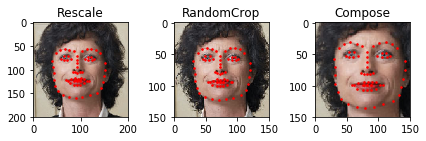

In [46]:
# compose transform
'''
    To group together various image preprocessing techniques,
    we can use torchvision.transforms.Compose 
'''

scale = Rescale(output_size=(200,200))
crop = RandomCrop(output_size=(150,150))
composed = transforms.Compose([Rescale((200, 200)), 
                               RandomCrop((150, 150))])

#apply preprocessing techniques on sample
fig = plt.figure()
n = 65
sample = face_dataset[n]
for i, tsfrm in enumerate([scale, crop, composed]):
    tsfrm_img = tsfrm(sample)
    ax = plt.subplot(1,3, i+1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__) #some oops in action
    show_landmarks(**tsfrm_img)
plt.show()

### Iterating through the dataset

1. Images are read from the file(one by one, thus saving RAM memory)
2. Image is transfromed, --> Data preprocessing
3. Images are augmented --> Data Augmentation

In [48]:
transformed_dataset = FaceLandmarksDataset(csv_file, root_dir, 
                                           transform = transforms.Compose([
                                                Rescale((256,256)),
                                                RandomCrop((224,224)),
                                                ToTensor()
                                            ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['landmarks'].size())
    if i==5:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])
4 torch.Size([3, 224, 224]) torch.Size([68, 2])
5 torch.Size([3, 224, 224]) torch.Size([68, 2])


Note : All the different components which help us to complete our tasks are very beautifully arranged into different classes. This is a very good approach of writing code as it helps to keep it clean and reusable.